In [1]:
"""
构造基础pipeline
"""

from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import pipeline

# 加载模型和 tokenizer
model_name = "langboat/mengzi-t5-base"
tokenizer = T5Tokenizer.from_pretrained("./model/mengzi-t5-base")
model = T5ForConditionalGeneration.from_pretrained("./model/mengzi-t5-base")

# 创建 pipeline
qa_pipeline = pipeline(
    task="text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=64  # 控制生成长度
)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cuda:0


In [2]:
"""
基本示例测试
"""
test_result = qa_pipeline("中国的首都是<extra_id_0>。")
print(test_result)


[{'generated_text': '中国'}]


In [3]:

"""
QA样例测试
发现不能直接使用，接下来构造数据集去微调
"""
# 示例数据
sample = {
    "context": "年基准利率4.35%。 从实际看,贷款的基本条件是: 一是中国大陆居民,年龄在60岁以下; 二是有稳定的住址和工作或经营地点; 三是有稳定的收入来源; 四是无不良信用记录,贷款用途不能作为炒股,赌博等行为; 五是具有完全民事行为能力。",
    "question": "2017年银行贷款基准利率",
    "answer": "年基准利率4.35%"
}

# 构造输入文本（prompt）
input_text = f"阅读理解：问题是“{sample['question']}”，文章是“{sample['context']}”。答案是"

# 生成答案
result = qa_pipeline(input_text)

print(input_text)
print(result)

阅读理解：问题是“2017年银行贷款基准利率”，文章是“年基准利率4.35%。 从实际看,贷款的基本条件是: 一是中国大陆居民,年龄在60岁以下; 二是有稳定的住址和工作或经营地点; 三是有稳定的收入来源; 四是无不良信用记录,贷款用途不能作为炒股,赌博等行为; 五是具有完全民事行为能力。”。答案是
[{'generated_text': ''}]


In [5]:
# dataset.py

import json
from torch.utils.data import Dataset
from typing import List, Dict, Union
import os


class LCSTS(Dataset):
    """
    适用于 T5 等 seq2seq 模型的中文阅读理解 Dataset。
    输入文件为 JSON 格式，每行一个样本：
    {"context": "...", "question": "...", "answer": "...", "id": 0}

    将构造：
        source: "问题：{question} 上下文：{context} 答案："
        target: "{answer}"
    """
    def __init__(self, data_path: str):
        """
        Args:
            data_path (str): JSON 文件路径，每行一个 JSON 对象
        """
        self.data = []
        self._load_data(data_path)

    def _load_data(self, data_path: str):
        """按行读取 JSON 文件"""
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"数据文件未找到: {data_path}")

        with open(data_path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if not line:
                    continue
                try:
                    sample = json.loads(line)
                    self.data.append({
                        'id': sample.get('id', f'line_{line_num}'),
                        'context': sample['context'].strip(),
                        'question': sample['question'].strip(),
                        'answer': sample['answer'].strip()
                    })
                except json.JSONDecodeError as e:
                    print(f"第 {line_num} 行 JSON 解析错误: {e}")
                    continue
                except KeyError as e:
                    print(f"第 {line_num} 行缺少字段: {e}")
                    continue

        if len(self.data) == 0:
            raise ValueError(f"未能从 {data_path} 加载任何有效数据")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx) -> Dict[str, str]:
        sample = self.data[idx]
        source_text = f"问题：{sample['question']} 上下文：{sample['context']} 答案："
        target_text = f"{sample['answer']}"
        return {
            "source_text": source_text,
            "target_text": target_text,
            "id": sample['id']
        }



In [6]:
train_dataset = LCSTS("./data/DuReaderQG/train.json")
dev_dataset = LCSTS("./data/DuReaderQG/dev.json")

print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(dev_dataset)}")

# 打印第一个样本
print("\n示例输入 (source):")
print(train_dataset[0]['source_text'])
print("\n示例输出 (target):")
print(train_dataset[0]['target_text'])
print(f"id: {train_dataset[12]['id']}")

训练集大小: 14520
验证集大小: 984

示例输入 (source):
问题：仙剑奇侠传3第几集上天界 上下文：第35集雪见缓缓张开眼睛，景天又惊又喜之际，长卿和紫萱的仙船驶至，见众人无恙，也十分高兴。众人登船，用尽合力把自身的真气和水分输给她。雪见终于醒过来了，但却一脸木然，全无反应。众人向常胤求助，却发现人世界竟没有雪见的身世纪录。长卿询问清微的身世，清微语带双关说一切上了天界便有答案。长卿驾驶仙船，众人决定立马动身，往天界而去。众人来到一荒山，长卿指出，魔界和天界相连。由魔界进入通过神魔之井，便可登天。众人至魔界入口，仿若一黑色的蝙蝠洞，但始终无法进入。后来花楹发现只要有翅膀便能飞入。于是景天等人打下许多乌鸦，模仿重楼的翅膀，制作数对翅膀状巨物。刚佩戴在身，便被吸入洞口。众人摔落在地，抬头发现魔界守卫。景天和众魔套交情，自称和魔尊重楼相熟，众魔不理，打了起来。 答案：

示例输出 (target):
第35集
id: 12


In [7]:
def collate_fn(batch):
    """
    将一批原始文本样本转换为模型输入。
    batch: List[Dict], 来自 LCSTS 的输出
    """
    sources = [item["source_text"] for item in batch]
    targets = [item["target_text"] for item in batch]
    ids = [item["id"] for item in batch]

    # Tokenize inputs (source)
    model_inputs = tokenizer(
        sources,
        max_length=512,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

    # Tokenize targets (labels)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=32,
            padding=True,
            truncation=True,
            return_tensors="pt"
        )

    # 关键：将 label 中的 padding token 替换为 -100
    # 因为 tokenizer.pad_token_id 对应的是 padding 位置
    labels_input_ids = labels["input_ids"].clone()
    labels_input_ids[labels_input_ids == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels_input_ids

    # model_inputs["id"] = ids

    return model_inputs

In [8]:
# 训练 DataLoader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,                    # 根据显存调整（T5-base 建议 4~16）
    shuffle=True,
    collate_fn=collate_fn
)

# 验证集 DataLoader
eval_dataloader = DataLoader(
    dev_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)


def safe_decode(tokenizer, tensor_or_list, skip_special_tokens=True):
    """
    安全地解码包含 -100 的 label tensor
    """
    # 转为 list
    if hasattr(tensor_or_list, 'tolist'):
        ids = tensor_or_list.tolist()
    else:
        ids = tensor_or_list

    # 过滤掉 -100，或者替换为 pad_token_id（如果你想保留位置）
    cleaned = [token_id for token_id in ids if token_id != -100]
    
    # 如果你想保留长度，可以用 pad_token_id 替代 -100
    # cleaned = [token_id if token_id != -100 else tokenizer.pad_token_id for token_id in ids]

    return tokenizer.decode(cleaned, skip_special_tokens=skip_special_tokens)


# -------------------------------
# 3. 测试一个 batch
# -------------------------------
batch = next(iter(train_dataloader))
print("Input IDs shape:", batch["input_ids"].shape)    # [B, L_src]
print("Input IDs:", batch["input_ids"])    # [B, L_src]

print("Attention Mask shape:", batch["attention_mask"].shape)
print("Attention Mask:", batch["attention_mask"])


print("Labels shape:", batch["labels"].shape)          # [B, L_tgt]
print("Labels:", batch["labels"])          # [B, L_tgt]


print("Decoding one input:", tokenizer.decode(batch["input_ids"][0], skip_special_tokens=False))
# print("Decoding one label:", tokenizer.decode(batch["labels"][0], skip_special_tokens=True))
print("Decoding one label (safe):", safe_decode(tokenizer, batch["labels"][0], skip_special_tokens=True))

Input IDs shape: torch.Size([8, 475])
Input IDs: tensor([[  143,    13,  3555,  ...,     0,     0,     0],
        [  143,    13,  2242,  ...,     0,     0,     0],
        [  143,    13, 18377,  ...,     0,     0,     0],
        ...,
        [  143,    13, 25575,  ...,  2125,    13,     1],
        [  143,    13,  8932,  ...,     0,     0,     0],
        [  143,    13,   171,  ...,     0,     0,     0]])
Attention Mask shape: torch.Size([8, 475])
Attention Mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Labels shape: torch.Size([8, 7])
Labels: tensor([[11195, 12237,     1,  -100,  -100,  -100,  -100],
        [20741,   212,     1,  -100,  -100,  -100,  -100],
        [ 2838,   229,  7639,   370,     1,  -100,  -100],
        [ 9202,   212,     1,  -100,  -100,  -100,  -100],
        [ 1152,   490,     1,  -100

/home/clione/miniconda3/envs/learn_transformer/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [9]:

from tqdm.auto import tqdm
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_loop(dataloader, model, optimizer, lr_scheduler, epoch, total_loss):
    progress_bar = tqdm(range(len(dataloader)))
    progress_bar.set_description(f'loss: {0:>7f}')
    finish_batch_num = (epoch-1) * len(dataloader)
    
    model.train()
    for batch, batch_data in enumerate(dataloader, start=1):
        batch_data = batch_data.to(device)
        outputs = model(**batch_data)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        progress_bar.set_description(f'loss: {total_loss/(finish_batch_num + batch):>7f}')
        progress_bar.update(1)
    avg_train_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch}, Average Training Loss: {avg_train_loss:.4f}")
    return avg_train_loss


In [10]:
# 下载必要的 nltk 数据（只需运行一次）
import nltk

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

In [11]:
import jieba  # 推荐用于中文
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def test_loop(dataloader, model, tokenizer, device="cuda"):
    model.eval()
    bleu_1_score = 0.0
    bleu_2_score = 0.0
    bleu_3_score = 0.0
    bleu_4_score = 0.0
    num_samples = 0

    
    smoothie = SmoothingFunction().method1
    

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']  # shape: (batch_size, seq_len)

            # 生成预测
            generated_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=32,
                num_beams=5,
                early_stopping=True
            )

            # 解码：生成文本
            predictions = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            # 解码：真实标签
            # 注意：labels 中的 -100 是被忽略的 padding，我们先把它变成 tokenizer.pad_token_id
            # 或直接 decode
            try:
                # 创建 label mask，忽略 -100
                labels_for_decode = labels.clone()
                labels_for_decode[labels_for_decode == -100] = tokenizer.pad_token_id
                references_list = tokenizer.batch_decode(labels_for_decode, skip_special_tokens=True)
            except:
                # fallback
                references_list = tokenizer.batch_decode(labels, skip_special_tokens=True, clean_up_tokenization_spaces=True)

            # 遍历每个样本
            for pred, ref in zip(predictions, references_list):
                # ✅ 确保 pred 和 ref 都是字符串
                if not isinstance(pred, str) or not isinstance(ref, str):
                    print(f"Warning: pred 或 ref 不是字符串，类型: {type(pred)}, {type(ref)}")
                    continue

                # 中文分词
                pred_tokens = list(jieba.cut(pred.strip())) if pred.strip() else []
                ref_tokens = list(jieba.cut(ref.strip())) if ref.strip() else []

                # 如果生成为空，BLEU 为 0
                if len(pred_tokens) == 0 or len(ref_tokens) == 0:
                    bleu_1, bleu_2, bleu_3, bleu_4 = 0.0, 0.0, 0.0, 0.0
                else:
                    bleu_1 = sentence_bleu([ref_tokens], pred_tokens, weights=(1,), smoothing_function=smoothie)
                    bleu_2 = sentence_bleu([ref_tokens], pred_tokens, weights=(0.5, 0.5), smoothing_function=smoothie)
                    bleu_3 = sentence_bleu([ref_tokens], pred_tokens, weights=(1/3,)*3, smoothing_function=smoothie)
                    bleu_4 = sentence_bleu([ref_tokens], pred_tokens, weights=(0.25,)*4, smoothing_function=smoothie)

                # ✅ 这里 bleu_* 都是 float，+= 是合法的
                bleu_1_score += bleu_1 # type: ignore
                bleu_2_score += bleu_2 # type: ignore
                bleu_3_score += bleu_3 # type: ignore
                bleu_4_score += bleu_4 # type: ignore
                num_samples += 1

    # 计算平均值
    if num_samples > 0:
        bleu_1_score /= num_samples
        bleu_2_score /= num_samples
        bleu_3_score /= num_samples
        bleu_4_score /= num_samples

    print(f"BLEU-1: {bleu_1_score:.4f}")
    print(f"BLEU-2: {bleu_2_score:.4f}")
    print(f"BLEU-3: {bleu_3_score:.4f}")
    print(f"BLEU-4: {bleu_4_score:.4f}")

    avg_bleu = (bleu_1_score + bleu_2_score + bleu_3_score + bleu_4_score) / 4

    return {
        "bleu-1": bleu_1_score,
        "bleu-2": bleu_2_score,
        "bleu-3": bleu_3_score,
        "bleu-4": bleu_4_score,
        "avg_bleu": avg_bleu
    }

In [23]:
res = test_loop(eval_dataloader, model, tokenizer)
print(f"基准测试结果为：\n{res}")

/home/clione/miniconda3/envs/learn_transformer/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.379 seconds.
Prefix dict has been built successfully.


BLEU-1: 0.0000
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
基准测试结果为：
{'bleu-1': 1.779224737958248e-05, 'bleu-2': 6.825046021354255e-06, 'bleu-3': 6.198545411492534e-06, 'bleu-4': 5.913680101924784e-06}


In [12]:

from torch.optim import AdamW
from transformers import get_scheduler

learning_rate = 2e-5
epoch_num = 3

optimizer = AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=epoch_num*len(train_dataloader),
)

train_losses = []
valid_bleu_scores = []
epochs = []

total_loss = 0.
best_avg_bleu = 0.
for t in range(epoch_num):
    print(f"Epoch {t+1}/{epoch_num}\n-------------------------------")
    
    avg_loss = train_loop(train_dataloader, model, optimizer, lr_scheduler, t+1, total_loss)
    train_losses.append(avg_loss)


    valid_bleu = test_loop(eval_dataloader, model, tokenizer)
    bleu_score = valid_bleu['avg_bleu']
    valid_bleu_scores.append(bleu_score)

    
    if bleu_score > best_avg_bleu:
        best_avg_bleu = bleu_score
        print('saving new weights...\n')
        torch.save(model.state_dict(), f'epoch_{t+1}_valid_blue1_{best_avg_bleu:0.4f}_model_weights.bin')

    epochs.append(t + 1)
print("Done!")



Epoch 1/3
-------------------------------


  0%|          | 0/1815 [00:00<?, ?it/s]

/home/clione/miniconda3/envs/learn_transformer/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Epoch 1, Average Training Loss: 0.9187


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.419 seconds.
Prefix dict has been built successfully.


BLEU-1: 0.6403
BLEU-2: 0.5255
BLEU-3: 0.4105
BLEU-4: 0.3288
saving new weights...

Epoch 2/3
-------------------------------


  0%|          | 0/1815 [00:00<?, ?it/s]

Epoch 2, Average Training Loss: 0.4184
BLEU-1: 0.6498
BLEU-2: 0.5309
BLEU-3: 0.4099
BLEU-4: 0.3290
saving new weights...

Epoch 3/3
-------------------------------


  0%|          | 0/1815 [00:00<?, ?it/s]

Epoch 3, Average Training Loss: 0.2750
BLEU-1: 0.6548
BLEU-2: 0.5383
BLEU-3: 0.4215
BLEU-4: 0.3379
saving new weights...

Done!


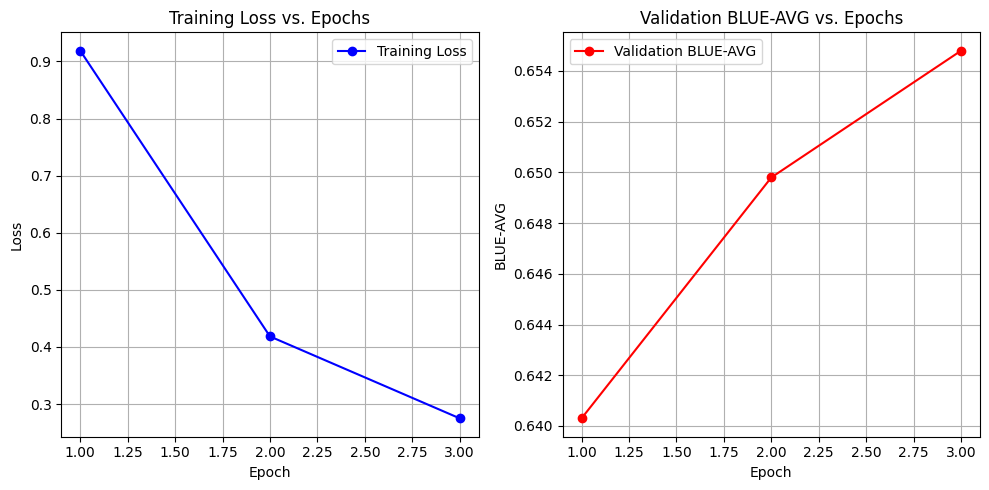

<Figure size 640x480 with 0 Axes>

In [ ]:
"""

"""

import matplotlib.pyplot as plt

import numpy as np

plt.figure(figsize=(10, 5))

# 子图 1：训练 loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 子图 2：验证 Rouge
plt.subplot(1, 2, 2)
plt.plot(epochs, valid_bleu_scores, 'ro-', label='Validation BLUE-AVG')
plt.title('Validation BLUE-AVG vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('BLUE-AVG')
plt.legend()
plt.grid(True)

# 调整布局
plt.tight_layout()
plt.show()

# 可选：保存图像
plt.savefig('training_curve.png', dpi=300)

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# 加载 tokenizer
tokenizer = T5Tokenizer.from_pretrained("./model/mengzi-t5-base")

# 加载模型结构
model = T5ForConditionalGeneration.from_pretrained("./model/mengzi-t5-base")

# 🔁 加载你微调过的权重
model.load_state_dict(torch.load("epoch_3_valid_blue1_0.4881_model_weights.bin", map_location=device))

# 将模型移到 GPU（如果可用）
model.to(device)
model.eval()  # 推理模式

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):